# prep

In [281]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import scipy.io as sio
from tqdm import tqdm
from IPython.display import clear_output

import os
import pickle

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [282]:
local_flag = False
if local_flag:
    repo_dir = r'D:\repo\inter_data\inter'.replace("\\", "/") # under env dimred
else:
    repo_dir = r'C:\Users\ll357\Documents\inter'.replace("\\", "/")
os.chdir(repo_dir)
from src import adp

In [284]:
dir_inter = r'Z:\All_Staff\home\lan\Data\2P_images\mat_inter/'.replace('\\', '/')
dir_file = dir_inter + 'adp_dataset_master.xlsx'
data_info = pd.read_excel(dir_file)
data_info.head()

meta = data_info[(data_info.paradigm == 'grating') 
                 & (data_info.area == 'LM')
                 & ((data_info.cellpose_seg == True) | (data_info.manual_seg == True))] # ensure segmentation
meta = meta.reset_index(drop=True)
nset = meta.shape[0]
print(meta.area.value_counts(), nset)

# meta_LM = meta.copy()
# meta_LM.tail()

LM    22
Name: area, dtype: int64 22


In [285]:
meta = data_info[(data_info.paradigm == 'grating') 
                 & (data_info.area == 'V1') 
                 & (data_info.gcamp == '6s') # avoid mixing in gcamp8f
                 & ((data_info.cellpose_seg == True) | (data_info.manual_seg == True))] # there are 2 data in V1 that haven't been segmented due to cellpose failing with low quality tiff
meta = meta.reset_index(drop=True)
nset = meta.shape[0]
print(meta.area.value_counts(), nset)

meta_V1 = meta.copy()
meta_V1

V1    6
Name: area, dtype: int64 6


,mouse,date,area,depth,num,cellpose_seg,manual_seg,paradigm,gcamp,AWS,note
0,1323,200720,V1,200.0,3,NaN,True,grating,6s,1.0,NaN
1,1324,200728,V1,200.0,3,NaN,True,grating,6s,NaN,NaN
2,1322,200803,V1,200.0,2,NaN,True,grating,6s,NaN,NaN
3,1328,201015,V1,200.0,4,NaN,True,grating,6s,1.0,NaN
4,1329,201209,V1,200.0,2,NaN,True,grating,6s,NaN,NaN
5,1337,210120,V1,150.0,3,1.0,NaN,grating,6s,NaN,NaN


In [286]:
meta = data_info[(data_info.paradigm == 'grating') 
                 & (data_info.area == 'LI') 
                 & (data_info.gcamp == '6s') # avoid mixing in gcamp8f
                 & (data_info.manual_seg != 'TODO')] # 2 LI data still need manual segm
meta = meta.reset_index(drop=True)
nset = meta.shape[0]
print(meta.area.value_counts(), nset)

meta_LI = meta.copy()
meta_LI

LI    20
Name: area, dtype: int64 20


,mouse,date,area,depth,num,cellpose_seg,manual_seg,paradigm,gcamp,AWS,note
0,1323,200723,LI,200.0,3,NaN,True,grating,6s,1.0,NaN
1,1322,200806,LI,200.0,3,NaN,True,grating,6s,1.0,NaN
2,1328,201202,LI,200.0,3,NaN,True,grating,6s,1.0,NaN
3,1328,201202,LI,150.0,4,NaN,True,grating,6s,1.0,NaN
4,1329,210113,LI,200.0,4,NaN,RECHECK,grating,6s,NaN,"terrible timecourse by cellpose, must manual seg"
5,1329,210113,LI,150.0,6,NaN,RECHECK,grating,6s,NaN,NaN
6,1337,210203,LI,200.0,3,NaN,RECHECK,grating,6s,NaN,NaN
7,1337,210203,LI,150.0,4,NaN,RECHECK,grating,6s,NaN,NaN
8,1339,210930,LI,200.0,2,NaN,RECHECK,grating,6s,NaN,NaN
9,1339,210930,LI,150.0,3,NaN,RECHECK,grating,6s,NaN,NaN


# batch write df_tidy

In [291]:
meta = pd.concat([meta_V1, meta_LM, meta_LI], axis=0).reset_index(drop=True)
# meta = meta_LI.copy()
nset = len(meta)

for iset in tqdm(range(nset)):
    print(f'iset={iset}, nset={nset}')


    ## load data
    mouse = meta.loc[iset, 'mouse'].astype(str)
    imouse = 'i' + mouse
    date = meta.loc[iset, 'date'].astype(str)
    area = meta.loc[iset, 'area']
    sess = '00' + meta.loc[iset, 'num'].astype(str)
    print(mouse, date, area, sess)
    dir_identifier = f'{area}_{imouse}_{date}_{sess}'

    mat_inter = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter/'.replace('\\', '/')
    for dirname in os.listdir(mat_inter):
        if dir_identifier in dirname:
            dir_data = mat_inter + dirname
            break

    stim_id, resp_ad, resp_tg = adp.load_resp_trial(os.path.join(dir_data), vis_filter=False) # already sliced by resp time window from matlab. only differentiating isi in resp_tg by indexing into trial. match isi_nframe
    ## NOTE: stim_id contains the final trial, which should be cut off due to incomplete trial, to match trace_by_trial


    ## construct dfof
    R1_dfof = resp_ad.flatten() # cell x trial, row major flatten
    R2_dfof = resp_tg.flatten()
    dfof = np.hstack((R1_dfof, R2_dfof)) # sort by cell_id, then trial_id, finally resp_id


    ## construct cell, trial, resp id
    ncell = resp_ad.shape[0]
    ntrial = resp_ad.shape[1]
    cell_id = np.repeat(np.arange(ncell), ntrial) # repeat cell id arr for ntrial times == sort by cell_id, then trial_id
    cell_id = np.hstack((cell_id, cell_id)) # stack two copies for R1 and R2. finally sort by resp_id

    trial_id = np.tile(np.arange(ntrial), ncell) # for each cell, go over all trials
    trial_id = np.hstack((trial_id, trial_id))

    len_df = ncell * ntrial * 2 # 2 for (R1, R2)
    resp_id = ['R1'] * int(len_df/2) + ['R2'] * int(len_df/2) # first half is flattened resp_ad, second half is flattened resp_tg


    ## construct stim info col: stim 2 orientation, stim 1 orien, isi, adapter contrast
    trial_stim_orien = [item[0] for item in stim_id['stim_ori']] # print(np.sort(np.unique(trial_stim_orien)))
    trial_stim_orien_dict = {} ## map stim2 orientation to int
    for i, item in enumerate(np.sort(np.unique(trial_stim_orien))):
        trial_stim_orien_dict[item] = i
    trial_stim_orien_int = [trial_stim_orien_dict[item] for item in trial_stim_orien]

    trial_isi_nframe = [item[0] for item in stim_id['isi_nframe']]
    trial_adapter_contrast = [item[0] for item in stim_id['adapter_contrast']]

    trial_stim_orien_int = trial_stim_orien_int[:ntrial] # if any stim info longer than ntrial, slice off the last one
    trial_isi_nframe = trial_isi_nframe[:ntrial]
    trial_adapter_contrast = trial_adapter_contrast[:ntrial]
    

    ## make stim info col: same as trial_id - tile then hsatck
    stim_id_col = np.tile(trial_stim_orien_int, ncell)
    isi_col = np.tile(trial_isi_nframe, ncell)
    ad_con_col = np.tile(trial_adapter_contrast, ncell)

    stim_id_col = np.hstack((stim_id_col, stim_id_col)) # stim2 orientation
    isi_col = np.hstack((isi_col, isi_col))
    ad_con_col = np.hstack((ad_con_col, ad_con_col))

    df_tidy = pd.DataFrame({'dfof': dfof, 'cell_id': cell_id, 'trial_id': trial_id, 'resp_id': resp_id, 
                            'isi': isi_col, 'stim1_contrast': ad_con_col, 
                            'stim2_id': stim_id_col,})
    df_tidy['area'] = area
    df_tidy['stim1_id'] = 0 # adapter (stim1) is always 0 deg / vertical gratings
    df_tidy.loc[(df_tidy.stim1_contrast == 0) & (df_tidy.resp_id == 'R1'), 'dfof'] = np.nan # set R1 to nan if no adapter (stim1_contrast == 0)
    df_tidy = df_tidy.dropna().reset_index(drop=True) # drop nan rows

    df_tidy['isi'] = df_tidy['isi'].apply(lambda x: 250 if x <= 10 else 750) # convert isi_nframe to ms. 250 ms is about 8 frames, 750 ms is about 22-23 frames
    df_tidy.loc[df_tidy.stim1_contrast == 0, 'isi'] = 6000 # set ISI to 6000 ms (equal to ITI) if no adapter (stim1_contrast == 0)


    ## vis cell filter, well_fit filter, & img driven cell-stim filter
    df_tidy['filter_cell_vis'] = np.nan
    df_tidy['filter_cell_well_fit'] = np.nan
    df_tidy['filter_cell_stim'] = np.nan

    with open(os.path.join(dir_data, 'vis_driven.pickle'), 'rb') as f:
        filter_file = pickle.load(f)
    filter_cell_stim = filter_file['img_driven']
    filter_cell_vis = filter_file['vis_driven']

    well_fit = sio.loadmat(os.path.join(dir_data, 'fit_bootstrap_90perc.mat'))
    well_fit_cell = np.array([x[0] for x in well_fit['well_fit_cell']])

    for icell in np.arange(filter_cell_stim.shape[0]): # filter_cell_stim is ncell x nstim
        df_tidy.loc[df_tidy['cell_id']==icell, 'filter_cell_vis'] = filter_cell_vis[icell][0] # filter_cell_vis is a list of list
        df_tidy.loc[df_tidy['cell_id']==icell, 'filter_cell_well_fit'] = well_fit_cell[icell]
        for istim in np.arange(filter_cell_stim.shape[1]):
            df_tidy.loc[(df_tidy['stim2_id']==istim) & (df_tidy['cell_id']==icell), 'filter_cell_stim'] = filter_cell_stim[icell, istim]
    # df_tidy.filter_cell_vis.value_counts(), df_tidy.filter_cell_stim.value_counts()


    ## cell tuning in 3 possible ISI, 2 runs (each run uses half of the trials)
    fit_tuning_half = sio.loadmat(os.path.join(dir_data, 'fit_tuning_half_trials.mat'))
    ori_pref_run1 = fit_tuning_half['ori_pref_runs'][:, :, 0] # ncell x 3isi x 2run, [noad vs ad750 vs ad250]
    ori_pref_run2 = fit_tuning_half['ori_pref_runs'][:, :, 1]

    # ori_pref_runs_sorted = well_fit['ori_pref_runs']
    # # ori_pref_runs_sorted = np.array([np.sort(x) for x in well_fit['ori_pref_runs']]) # ncell x nrun. sort each row of ori_pref_runs
    # # for icell in np.arange(10):
    # #     plt.plot(ori_pref_runs_sorted[icell, :])

    # percentile_threshold = 0.9
    # # if area == 'LI':
    # #     percentile_threshold = 0.7 # taken from well_fit_cell_criteria(_relax).m, only relax for LI
    # nrun = ori_pref_runs_sorted.shape[1]
    # rand_idx = np.random.randint(nrun*(1-percentile_threshold), nrun*percentile_threshold, size=2) # # bc well_fit cells are defined as: 90% of bootstrapped ori_pref within 22.5 deg, randomly select 2 indices between 100-900 in ori_pref_runs_sorted
    # ori_pref_noad1 = ori_pref_runs_sorted[:, rand_idx[0]] # ncell x 1
    # ori_pref_noad2 = ori_pref_runs_sorted[:, rand_idx[1]]


    ## goodness of fit (R square) in isi 250 or 750
    fit_tuning = sio.loadmat(os.path.join(dir_data, 'fit_tuning_isi3.mat')) # fit_tuning['fit_param'].shape # ncell x nparam x nstim
    R_square = fit_tuning['fit_param'][:, -1, :] # ncell x nstim, final param is R_square of fit
    R_square_750 = R_square[:, 1] # use R_sq to determine well_fit_ad
    R_square_250 = R_square[:, 2]
    well_fit_ad_250 = R_square_250 >= np.percentile(R_square_250, 50) # ncell x 1. only take top 50% of R_sq
    well_fit_ad_750 = R_square_750 >= np.percentile(R_square_750, 50)


    ## write cell property to df_tidy
    ncell = df_tidy.cell_id.unique().shape[0]
    for icell in np.arange(ncell):
        df_tidy.loc[(df_tidy.cell_id == icell), 'ori_pref_noad'] = ori_pref_run1[icell, 0] # ori_pref_run1 is ncell x 3isi, [noad vs ad750 vs ad250]
        df_tidy.loc[(df_tidy.cell_id == icell), 'ori_pref_ad_750'] = ori_pref_run1[icell, 1]
        df_tidy.loc[(df_tidy.cell_id == icell), 'ori_pref_ad_250'] = ori_pref_run1[icell, 2]

        df_tidy.loc[(df_tidy.cell_id == icell), 'ori_pref_noad1'] = ori_pref_run1[icell, 0] # for control plot
        df_tidy.loc[(df_tidy.cell_id == icell), 'ori_pref_noad2'] = ori_pref_run2[icell, 0]

        df_tidy.loc[df_tidy['cell_id']==icell, 'filter_cell_well_fit_ad_250'] = well_fit_ad_250[icell]
        df_tidy.loc[df_tidy['cell_id']==icell, 'filter_cell_well_fit_ad_750'] = well_fit_ad_750[icell]
    
    # break

    ## save df_tidy as csv
    df_tidy.to_csv(os.path.join(dir_data, 'df_tidy_fit_tuning_half_trials.csv'), index=False)

clear_output()

# batch load df_tidy

In [292]:
meta = pd.concat([meta_V1, meta_LM, meta_LI], axis=0).reset_index(drop=True)
# meta = meta_LI.copy()
meta.sample(5, random_state=0)

,mouse,date,area,depth,num,cellpose_seg,manual_seg,paradigm,gcamp,AWS,note
29,1322,200806,LI,200.0,3,NaN,True,grating,6s,1.0,NaN
4,1329,201209,V1,200.0,2,NaN,True,grating,6s,NaN,NaN
26,1381,230307,LM,200.0,3,1.0,NaN,grating,6s,NaN,NaN
30,1328,201202,LI,200.0,3,NaN,True,grating,6s,1.0,NaN
32,1329,210113,LI,200.0,4,NaN,RECHECK,grating,6s,NaN,"terrible timecourse by cellpose, must manual seg"


In [293]:
nset = len(meta)
df_tidy = pd.DataFrame()

for iset in range(nset):
    print(f'iset={iset}, nset={nset}')

    mouse = meta.loc[iset, 'mouse'].astype(str)
    imouse = 'i' + mouse
    date = meta.loc[iset, 'date'].astype(str)
    area = meta.loc[iset, 'area']
    sess = '00' + meta.loc[iset, 'num'].astype(str)
    print(imouse, date, area, sess)
    dir_identifier = f'{area}_{imouse}_{date}_{sess}'

    dir_data = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter/'.replace('\\', '/')
    csv_filename = 'df_tidy_fit_tuning_half_trials.csv'
    try:
        df_tidy_now = pd.read_csv(os.path.join(dir_data, dir_identifier, csv_filename))
    except:
        dir_identifier = dir_identifier + '_cellpose'
        df_tidy_now = pd.read_csv(os.path.join(dir_data, dir_identifier, csv_filename))

    df_tidy_now['mouse'] = mouse
    df_tidy_now['date'] = date
    df_tidy_now['sess'] = sess
    df_tidy_now['cell_id'] = (df_tidy_now.date.astype(str) + '_' 
                               + df_tidy_now.sess.astype(str) + '_' 
                               + df_tidy_now.cell_id.astype(str)) # cell_id adjusted to be unique across mice, dates, sessions
    df_tidy = pd.concat([df_tidy, df_tidy_now], axis=0).reset_index(drop=True)
    # break
    
clear_output()

In [294]:
print(df_tidy.mouse.unique(), 
      df_tidy.date.unique(), 
      df_tidy.sess.unique(), 
      df_tidy.area.unique(), 
      df_tidy.isi.unique(), 
      df_tidy.stim1_contrast.unique(), 
      df_tidy.stim2_id.unique(), 
      df_tidy.resp_id.unique())
df_tidy.sample(5, random_state=0)

['1323' '1324' '1322' '1328' '1329' '1337' '1338' '1350' '1351' '1380'
 '1373' '1381' '1339' '1374'] ['200720' '200728' '200803' '201015' '201209' '210120' '200721' '200729'
 '200804' '201119' '201127' '201217' '210127' '210325' '210805' '211020'
 '220228' '230221' '230302' '230307' '200723' '200806' '201202' '210113'
 '210203' '210930' '211028' '230110' '230228' '230309' '230323'] ['003' '002' '004' '006'] ['V1' 'LM' 'LI'] [ 750  250 6000] [1 0] [5 2 3 0 7 4 1 6] ['R1' 'R2']


,dfof,cell_id,trial_id,resp_id,isi,stim1_contrast,stim2_id,area,stim1_id,filter_cell_vis,...,ori_pref_noad,ori_pref_ad_750,ori_pref_ad_250,ori_pref_noad1,ori_pref_noad2,filter_cell_well_fit_ad_250,filter_cell_well_fit_ad_750,mouse,date,sess
2522359,0.064808,230323_003_32,8,R1,250,1,5,LI,0,False,...,45.000000,162.527850,60.088142,45.000000,179.737029,False,True,1374,230323,003
1603041,-0.010087,230302_004_128,272,R2,250,1,3,LM,0,True,...,170.290328,0.287615,172.995644,170.290328,165.619769,True,False,1373,230302,004
1370059,-0.063766,230221_003_34,411,R2,6000,0,6,LM,0,False,...,33.334788,135.000000,35.490009,33.334788,67.409489,False,True,1380,230221,003
2385126,-0.017126,230309_002_90,111,R2,250,1,3,LI,0,True,...,45.000000,84.508480,44.297625,45.000000,56.171587,True,True,1381,230309,002
123632,0.047451,200728_003_27,433,R2,6000,0,3,V1,0,True,...,95.956393,98.629334,95.660354,95.956393,89.631448,True,True,1324,200728,003


# adaptation by area

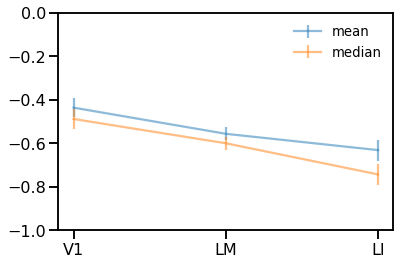

In [341]:
def adp_in_area(df_filter):

    gb_R1 = df_filter[(df_filter.stim2_id == 0) & (df_filter.resp_id == 'R1')].groupby(['area', 'cell_id']).sum()['dfof'].values
    gb_R2 = df_filter[(df_filter.stim2_id == 0) & (df_filter.resp_id == 'R2')].groupby(['area', 'cell_id']).sum()['dfof'].values
    gb_adp = (gb_R2 - gb_R1) / (gb_R1 + 1e-7)
    gb_adp = gb_adp[np.abs(gb_adp) < 5]

    return gb_adp

df_filter = df_tidy[df_tidy.isi == 250]
gb_adp_V1 = adp_in_area(df_filter[df_filter.area == 'V1'])
gb_adp_LM = adp_in_area(df_filter[df_filter.area == 'LM'])
gb_adp_LI = adp_in_area(df_filter[df_filter.area == 'LI'])

# plt.hist(gb_adp_V1, bins=50, alpha=.5, label='V1')
# plt.hist(gb_adp_LM, bins=50, alpha=.5, label='LM')
# plt.hist(gb_adp_LI, bins=50, alpha=.5, label='LI')
# plt.legend();

adp_mean_arr = [np.mean(gb_adp_V1), np.mean(gb_adp_LM), np.mean(gb_adp_LI)]
adp_med_arr = [np.median(gb_adp_V1), np.median(gb_adp_LM), np.median(gb_adp_LI)]
adp_sem_arr = [np.std(gb_adp_V1) / np.sqrt(len(gb_adp_V1)), 
               np.std(gb_adp_LM) / np.sqrt(len(gb_adp_LM)),
                np.std(gb_adp_LI) / np.sqrt(len(gb_adp_LI))]
plt.errorbar([1, 2, 3], adp_mean_arr, yerr=adp_sem_arr, label='mean', alpha=.5)
plt.errorbar([1, 2, 3], adp_med_arr, yerr=adp_sem_arr, label='median', alpha=.5)
plt.xticks([1, 2, 3], ['V1', 'LM', 'LI']);
plt.ylim([-1, 0]);
plt.legend(frameon=False);

dir_fig = r'C:\Users\ll357\Documents\inter\results\tuning bias'.replace('\\', '/')
plt.savefig(os.path.join(dir_fig, 'adp_grat8_by_area.pdf'))

# tuning bias
x: distance(pref_ori_unadapted, 0 deg adapter_ori).binned  
y: distance(pref_ori_unadapted, 0 deg) - distance(pref_ori_adapted, 0 deg)

## pref_ori for cell & isi
~~crude preference: take max-resp orientation as the preferred orien~~  
fitted preference: use pref from von mises curve fit

In [297]:
def bin_ori(x):
    # bin pref ori to 0, 45, 90
    if x < 30:
        return 0
    elif x <= 60:
        return 45
    else:
        return 90

def bin_ori_finer(x):
    # bin pref ori to n bins, with equal bin width
    nbin = 4 # n_edge = nbin + 1
    bin_width = 90 / nbin
    return (x // bin_width) * bin_width

def distance_from_adapter(x):
    # adapter is always 0 deg
    # x = 22.5*x # convert from stim id int to degree
    if x > 90:
        x = 180 - x
    return x


df_tidy['pref_unadapted_distance'] = df_tidy['ori_pref_noad'].apply(lambda x: distance_from_adapter(x)) # unadapted pref ori, distance from adapter
df_tidy['pref_unadapted_distance_bin'] = df_tidy['pref_unadapted_distance'].apply(lambda x: bin_ori(x)) # bin the distance to 0, 45, 90
# df_tidy['pref_unadapted_distance_bin'] = df_tidy['pref_unadapted_distance'].apply(lambda x: bin_ori_finer(x)) # bin the distance to 5 edges, 0, 22.5, 45, 67.5, 90

df_tidy.loc[(df_tidy.isi == 250), 'pref_adapted_distance'] = df_tidy['ori_pref_ad_250'].apply(lambda x: distance_from_adapter(x)) # isi 250 adapted pref ori, distance from adapter # TODO: refactor pref_ori_ad_250 similarly, so it's only one column of pref_ori_ad, but can filter by isi
df_tidy.loc[(df_tidy.isi == 750), 'pref_adapted_distance'] = df_tidy['ori_pref_ad_750'].apply(lambda x: distance_from_adapter(x)) # isi 750 adapted pref ori, distance from adapter
df_tidy['tuning_bias'] = df_tidy['pref_adapted_distance'] - df_tidy['pref_unadapted_distance'] # distance from adapter, adapted - unadapted. if tuning repelled from adapter, this is positive; attracted, negative

df_tidy.sample(5, random_state=0)

,dfof,cell_id,trial_id,resp_id,isi,stim1_contrast,stim2_id,area,stim1_id,filter_cell_vis,...,ori_pref_noad2,filter_cell_well_fit_ad_250,filter_cell_well_fit_ad_750,mouse,date,sess,pref_unadapted_distance,pref_unadapted_distance_bin,pref_adapted_distance,tuning_bias
2522359,0.064808,230323_003_32,8,R1,250,1,5,LI,0,False,...,179.737029,False,True,1374,230323,003,45.000000,45,60.088142,15.088142
1603041,-0.010087,230302_004_128,272,R2,250,1,3,LM,0,True,...,165.619769,True,False,1373,230302,004,9.709672,0,7.004356,-2.705316
1370059,-0.063766,230221_003_34,411,R2,6000,0,6,LM,0,False,...,67.409489,False,True,1380,230221,003,33.334788,45,NaN,NaN
2385126,-0.017126,230309_002_90,111,R2,250,1,3,LI,0,True,...,56.171587,True,True,1381,230309,002,45.000000,45,44.297625,-0.702375
123632,0.047451,200728_003_27,433,R2,6000,0,3,V1,0,True,...,89.631448,True,True,1324,200728,003,84.043607,90,NaN,NaN


In [298]:
df_control = df_tidy.copy()

df_control['pref_unadapted_distance'] = df_control['ori_pref_noad1'].apply(lambda x: distance_from_adapter(x)) # unadapted pref ori, distance from adapter
df_control['pref_unadapted_distance_bin'] = df_control['pref_unadapted_distance'].apply(lambda x: bin_ori(x)) # bin the distance to 0, 45, 90
# df_control['pref_unadapted_distance_bin'] = df_control['pref_unadapted_distance'].apply(lambda x: bin_ori_finer(x))

df_control['pref_adapted_distance'] = df_control['ori_pref_noad2'].apply(lambda x: distance_from_adapter(x))
df_control['tuning_bias'] = df_control['pref_adapted_distance'] - df_control['pref_unadapted_distance']

df_control.sample(5, random_state=0)

,dfof,cell_id,trial_id,resp_id,isi,stim1_contrast,stim2_id,area,stim1_id,filter_cell_vis,...,ori_pref_noad2,filter_cell_well_fit_ad_250,filter_cell_well_fit_ad_750,mouse,date,sess,pref_unadapted_distance,pref_unadapted_distance_bin,pref_adapted_distance,tuning_bias
2522359,0.064808,230323_003_32,8,R1,250,1,5,LI,0,False,...,179.737029,False,True,1374,230323,003,45.000000,45,0.262971,-44.737029
1603041,-0.010087,230302_004_128,272,R2,250,1,3,LM,0,True,...,165.619769,True,False,1373,230302,004,9.709672,0,14.380231,4.670560
1370059,-0.063766,230221_003_34,411,R2,6000,0,6,LM,0,False,...,67.409489,False,True,1380,230221,003,33.334788,45,67.409489,34.074701
2385126,-0.017126,230309_002_90,111,R2,250,1,3,LI,0,True,...,56.171587,True,True,1381,230309,002,45.000000,45,56.171587,11.171587
123632,0.047451,200728_003_27,433,R2,6000,0,3,V1,0,True,...,89.631448,True,True,1324,200728,003,84.043607,90,89.631448,5.587841


In [275]:
# dir_df = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter\df tidy for plots/'.replace('\\', '/')
# df_tidy.to_csv(os.path.join(dir_df, 'df_tidy_tuning_bias.csv'), index=False)
# df_control.to_csv(os.path.join(dir_df, 'df_tidy_tuning_bias_control.csv'), index=False)
## TODO: save as a single df, bc only a few columns are different

## tuning bias plot

In [351]:
df_filter = df_tidy[(df_tidy.trial_id > -1) # placeholder, always true
                    & (df_tidy.filter_cell_vis == True)
                  #   & (df_tidy.filter_cell_stim == True)
                    & (df_tidy.filter_cell_well_fit == True)
                    # & (df_tidy.filter_cell_well_fit_ad_250 == True)
                    & (df_tidy.isi == 250)
                    # & (df_tidy.filter_cell_well_fit_ad_750 == True)
                    # & (df_tidy.isi == 750)
                    ]

df_filter_control = df_control[(df_control.trial_id > -1) # placeholder, always true
                    & (df_control.filter_cell_vis == True)
                  #   & (df_control.filter_cell_stim == True)
                    & (df_control.filter_cell_well_fit == True)
                    # & (df_tidy.filter_cell_well_fit_ad_250 == True)
                    & (df_control.isi == 250)
                    # & (df_tidy.filter_cell_well_fit_ad_750 == True)
                    # & (df_tidy.isi == 750)
                    ]

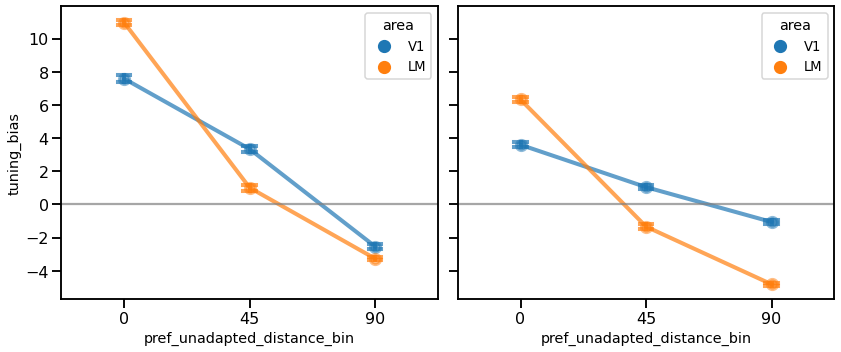

In [352]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
g1 = sns.pointplot(x='pref_unadapted_distance_bin', y='tuning_bias', 
                   data=df_filter[df_filter.area != 'LI'], hue='area',
                   errorbar=('ci', 68), errwidthfloat=1, capsize=.1,
                   ax=axes[0],
                   )
g2 = sns.pointplot(x='pref_unadapted_distance_bin', y='tuning_bias', 
                   data=df_filter_control[df_filter_control.area != 'LI'], hue='area',
                   errorbar=('ci', 68), errwidthfloat=1, capsize=.1,
                   ax=axes[1],
                  )
axes[0].axhline(0, color='gray', linestyle='-', alpha=.3);
axes[1].axhline(0, color='gray', linestyle='-', alpha=.3);

# # set y axis symlog
# axes[0].set_yscale('symlog')
# axes[1].set_yscale('symlog')

g2.set(ylabel=None) # remove ylabel
plt.setp(axes[0].collections, alpha=.5);
plt.setp(axes[1].collections, alpha=.5);
plt.setp(axes[0].lines, alpha=.7);
plt.setp(axes[1].lines, alpha=.7);
fig.tight_layout();

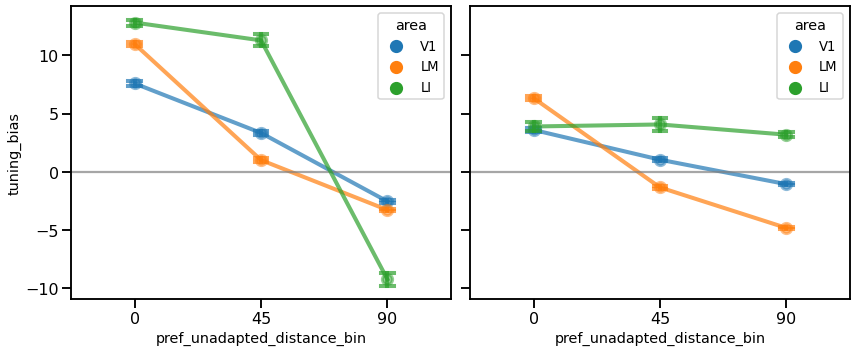

In [353]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
g1 = sns.pointplot(x='pref_unadapted_distance_bin', y='tuning_bias', data=df_filter, hue='area',
                   errorbar=('ci', 68), errwidthfloat=1, capsize=.1,
                   ax=axes[0],
                   )
g2 = sns.pointplot(x='pref_unadapted_distance_bin', y='tuning_bias', data=df_filter_control, hue='area',
                  errorbar=('ci', 68), errwidthfloat=1, capsize=.1,
                  ax=axes[1],
                  )
axes[0].axhline(0, color='gray', linestyle='-', alpha=.3);
axes[1].axhline(0, color='gray', linestyle='-', alpha=.3);

# # set y axis symlog
# axes[0].set_yscale('symlog')
# axes[1].set_yscale('symlog')

g2.set(ylabel=None) # remove ylabel
plt.setp(axes[0].collections, alpha=.5);
plt.setp(axes[1].collections, alpha=.5);
plt.setp(axes[0].lines, alpha=.7);
plt.setp(axes[1].lines, alpha=.7);
fig.tight_layout();

# plt.savefig(os.path.join(dir_fig, 'tuning_bias_by_area.pdf'))

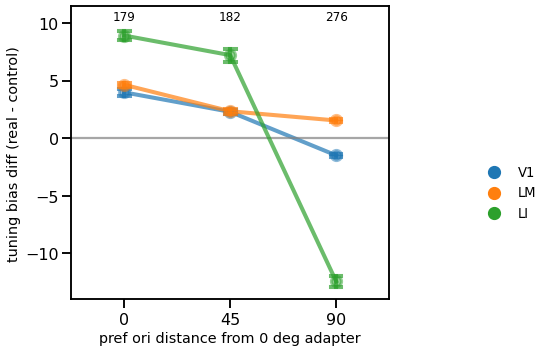

In [354]:
df_bias_diff = df_filter.copy()
df_bias_diff['tuning_bias'] = (df_filter['tuning_bias'] - df_filter_control['tuning_bias'])

fig, axes = plt.subplots(1, 1, figsize=(9, 5), sharey=True)
g1 = sns.pointplot(x='pref_unadapted_distance_bin', y='tuning_bias', data=df_bias_diff, hue='area',
                   errorbar=('ci', 68), errwidthfloat=1, capsize=.1,
                   ax=axes,
                   )

# annotation above each dot, ncell
ncell_bin = df_filter.groupby('pref_unadapted_distance_bin').cell_id.nunique().sort_index().values
ylim = axes.get_ylim()
axes.set_ylim(ylim[0], ylim[1] + 1)
for i in range(len(ncell_bin)):
    axes.annotate(str(ncell_bin[i]), (i, ylim[1] + 0.1), ha='center', va='center', size=12)

axes.legend(frameon=False, bbox_to_anchor=(1.5, 0.5))
g1.set(xlabel='pref ori distance from 0 deg adapter')
g1.set(ylabel='tuning bias diff (real - control)')
axes.axhline(0, color='gray', linestyle='-', alpha=.3);
plt.setp(axes.collections, alpha=.5);
plt.setp(axes.lines, alpha=.7);
fig.tight_layout();

# plt.savefig(os.path.join(dir_fig, 'tuning_bias_control_diff_by_area.pdf'))

In [355]:
df_filter.groupby(['pref_unadapted_distance_bin', 'area']).cell_id.nunique(), \
df_tidy.groupby(['pref_unadapted_distance_bin', 'area']).cell_id.nunique(), 

(pref_unadapted_distance_bin  area
 0                            LI        5
                              LM      117
                              V1       57
 45                           LI       10
                              LM       87
                              V1       85
 90                           LI       17
                              LM      175
                              V1       84
 Name: cell_id, dtype: int64,
 pref_unadapted_distance_bin  area
 0                            LI      327
                              LM      739
                              V1      216
 45                           LI      238
                              LM      417
                              V1      176
 90                           LI      305
                              LM      559
                              V1      191
 Name: cell_id, dtype: int64)

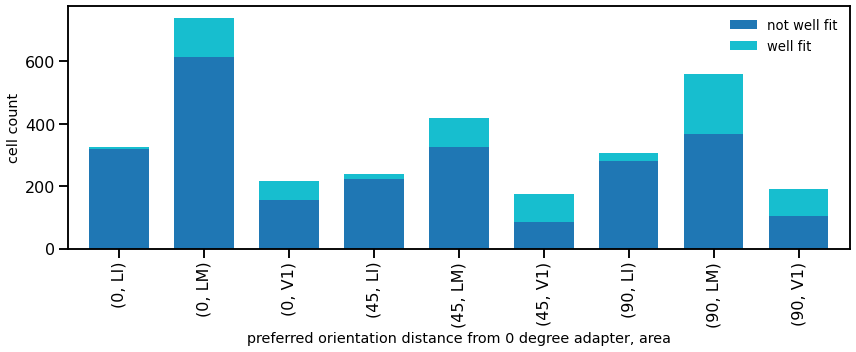

In [348]:
# stacked bar plot, colored by well_fit, for each area
df_tidy.groupby(['pref_unadapted_distance_bin', 'area', 'filter_cell_well_fit']).cell_id.nunique().unstack().plot(kind='bar', stacked=True, figsize=(12, 5), title='well_fit', colormap='tab10', legend='reverse', width=0.7);

# set legend frameon=False
plt.legend(frameon=False);

# set legend text content
plt.legend(['not well fit', 'well fit'], frameon=False);

plt.xlabel('preferred orientation distance from 0 degree adapter, area')
plt.ylabel('cell count')
plt.title('');
plt.tight_layout();

# plt.savefig(os.path.join(dir_fig, 'well_fit_by_area.pdf'))

# df for tuning curve

In [350]:
df_tuning = df_tidy[['dfof', 'cell_id', 'resp_id', 'isi', 'stim2_id', 
                    'area', 'filter_cell_vis', 'filter_cell_well_fit', 'filter_cell_well_fit_ad_250', 
                    'ori_pref_ad_250', 'ori_pref_noad', 
                    'pref_unadapted_distance', 'pref_unadapted_distance_bin', 'pref_adapted_distance', 'tuning_bias']]
df_tuning = df_tuning[(df_tuning.isi > -1) # placeholder, always true
                    # & (df_tuning.area == 'LI')
                    & (df_tuning.filter_cell_vis == True)
                    & (df_tuning.filter_cell_well_fit == True)
                    # & (df_tuning.filter_cell_well_fit_ad_250 == True) # only use cells that are well fit in both conditions: noad and ad 250
                    & ((df_tuning.isi == 250) | (df_tuning.isi == 6000))
                    # & (df_tuning.pref_unadapted_distance_bin == 90)
                    ] 
                    
df_tuning['tuning_noad'] = np.pi
df_tuning['tuning_250'] = np.pi

for icell in tqdm(df_tuning.cell_id.unique()):
    ## tuning curve when isi = 6000, no adapter
    tuning_noad = df_tuning.loc[(df_tuning.cell_id == icell) & (df_tuning.isi == 6000) & (df_tuning.resp_id == 'R2'), :].groupby(['stim2_id'], sort=True).agg(np.nanmean)['dfof'].values# groupby sort: sorted by key, aka stim2_id. take R2 of no adapter trials to get tuning curve when no adapter
    df_tuning.loc[(df_tuning.cell_id == icell), 'tuning_noad'] = df_tuning.loc[(df_tuning.cell_id == icell), 'tuning_noad'].apply(lambda x: tuning_noad)
    
    ## tuning curve when isi = 250
    tuning_250 = df_tuning.loc[(df_tuning.cell_id == icell) & (df_tuning.isi == 250) & (df_tuning.resp_id == 'R2'), :].groupby(['stim2_id'], sort=True).agg(np.nanmean)['dfof'].values
    df_tuning.loc[(df_tuning.cell_id == icell), 'tuning_250'] = df_tuning.loc[(df_tuning.cell_id == icell), 'tuning_250'].apply(lambda x: tuning_250)

df_tuning.sort_values(by=['tuning_bias'], inplace=True) # df_tuning sort by tuning_bias_distance
df_tuning.sample(5, random_state=0) # NOTE: where isi=6000, pref_adapted_distance and tuning_bias are NaN

100%|██████████| 637/637 [01:31<00:00,  6.93it/s]


,dfof,cell_id,resp_id,isi,stim2_id,area,filter_cell_vis,filter_cell_well_fit,filter_cell_well_fit_ad_250,ori_pref_ad_250,ori_pref_noad,pref_unadapted_distance,pref_unadapted_distance_bin,pref_adapted_distance,tuning_bias,tuning_noad,tuning_250
1431864,0.091252,230302_003_24,R2,6000,1,LM,True,1.0,False,69.983701,70.271948,70.271948,90,NaN,NaN,"[0.0631046946658928, 0.08631644337187894, 0.11...","[0.01766566223294723, 0.05058328542472208, 0.0..."
914327,0.006230,210127_003_58,R1,250,4,LM,True,1.0,True,79.045107,75.647372,75.647372,90,79.045107,3.397735,"[-0.011927335997344225, 0.042780367838578776, ...","[-0.027590681072318206, 0.015574299632528403, ..."
938236,-0.014828,210127_003_49,R2,250,5,LM,True,1.0,True,68.573857,51.376516,51.376516,45,68.573857,17.197341,"[0.050867797957229954, 0.05171386894375795, 0....","[0.02882323940351859, 0.11224010873484588, 0.3..."
126699,0.053651,200728_003_34,R2,6000,7,V1,True,1.0,False,144.928572,154.980702,25.019298,0,NaN,NaN,"[0.09792940420334809, 0.07179385315936487, 0.0...","[0.046342642949035666, 0.0588971591117751, 0.0..."
2198641,0.192849,230228_002_3,R2,6000,3,LI,True,1.0,True,50.747368,41.819138,41.819138,45,NaN,NaN,"[0.026358741969781864, 0.18673845669393735, 0....","[-0.00743369028408612, 0.14129635403344462, 0...."


## polar plot of tuning
before and after adaptation  
only use cells that are well fit in both conditions: noad and ad 250

In [337]:
# for icell in tqdm(df_tuning.cell_id.unique()):

#     tuning_noad = df_tuning[df_tuning.cell_id == icell].tuning_noad.values[0]
#     tuning_noad = np.append(tuning_noad, tuning_noad) # repeat 8 values twice to make 16 values for polar plot
#     tuning_noad = np.append(tuning_noad, tuning_noad[0]) # repeat first value at the end to close the circle
#     ori_pref_noad = df_tuning[df_tuning.cell_id == icell].ori_pref_noad.values[0]
#     # print('ori_pref_noad deg: ', np.round(ori_pref_noad, 2))
#     ori_pref_noad = ori_pref_noad * np.pi / 180 # degree to radian

#     tuning_250 = df_tuning[df_tuning.cell_id == icell].tuning_250.values[0]
#     tuning_250 = np.append(tuning_250, tuning_250)
#     tuning_250 = np.append(tuning_250, tuning_250[0])
#     ori_pref_ad_250 = df_tuning[df_tuning.cell_id == icell].ori_pref_ad_250.values[0]
#     # print('ori_pref_ad_250 deg: ', np.round(ori_pref_ad_250, 2))
#     ori_pref_ad_250 = ori_pref_ad_250 * np.pi / 180

#     tuning_bias = df_tuning[df_tuning.cell_id == icell].tuning_bias.values[0]
#     # print('no adapter: ', np.round(tuning_noad, 2))
#     # print('250 ms: ', np.round(tuning_250, 2))
#     # print('tuning_bias: ', np.round(tuning_bias, 2))

#     fig, ax = plt.subplots(1, 1, figsize=(12, 12), subplot_kw=dict(projection='polar'))
#     ax.plot(np.linspace(0, 2*np.pi, 17), tuning_noad, alpha=.5, linewidth=10)
#     ax.plot(np.linspace(0, 2*np.pi, 17), tuning_250, alpha=.5, linewidth=10)

#     # plot adapter ori as a line
#     min_val = np.min([np.min(tuning_noad), np.min(tuning_250)])
#     max_val = np.max([np.max(tuning_noad), np.max(tuning_250)])
#     # ax.plot([0, np.pi], [max_val, max_val], color='gray', linewidth=5, alpha=.5, label='adapter ori')

#     # ## plot 90 deg as a line
#     # ax.plot([np.pi/2, np.pi/2], [min_val, max_val], color='cyan', linewidth=5, alpha=.5, linestyle='-')
#     # ax.plot([np.pi*3/2, np.pi*3/2], [min_val, max_val], color='cyan', linewidth=5, alpha=.5, linestyle='-')

#     ## plot pref ori (noad) as a line
#     ax.plot([ori_pref_noad, ori_pref_noad], [min_val, max_val], color='blue', linewidth=5, alpha=.5, label='pref ori no adapter')
#     ori_pref_noad_opp = ori_pref_noad + np.pi # find opposite orientation of pref ori
#     if ori_pref_noad_opp > 2*np.pi:
#         ori_pref_noad_opp = ori_pref_noad_opp - 2*np.pi
#     ax.plot([ori_pref_noad_opp, ori_pref_noad_opp], [min_val, max_val], color='blue', linewidth=5, alpha=.5, linestyle='-')

#     ## plot pref ori (ad 250) as a line
#     ax.plot([ori_pref_ad_250, ori_pref_ad_250], [min_val, max_val], color='orange', linewidth=5, alpha=.5, label='pref ori isi=250')
#     ori_pref_ad_250_opp = ori_pref_ad_250 + np.pi
#     if ori_pref_ad_250_opp > 2*np.pi:
#         ori_pref_ad_250_opp = ori_pref_ad_250_opp - 2*np.pi
#     ax.plot([ori_pref_ad_250_opp, ori_pref_ad_250_opp], [min_val, max_val], color='orange', linewidth=5, alpha=.5, linestyle='-')

#     ## add text at top left
#     color = 'blue'
#     minus_flag = 'pos'
#     if tuning_bias < 0: # attractive bias
#         color = 'red'
#         minus_flag = 'neg'
#     plt.text(0.05, 0.9, f'tuning_bias: {np.round(tuning_bias, 2)}', transform=plt.gcf().transFigure, color=color, fontsize=16) # in cartesian coordinates

#     rticks = np.arange(0, max_val, step=0.05)
#     ax.set_rticks(rticks)  # fewer radial ticks

#     ax.set_xticks(np.linspace(0, 2*np.pi, 17))
#     ax.set_xticklabels(np.arange(0, 360+22.5, 22.5))
#     xticklabels = [label.get_text() for label in ax.get_xticklabels()]
#     xticklabels[-1] = '' # set final xticklabel invisible
#     ax.set_xticklabels(xticklabels)
#     ax.set_ylim(min_val, max_val)

#     ax.set_title('cell_id: {}'.format(icell))
#     ax.set_theta_zero_location("N")
#     ax.set_theta_direction(-1)
#     ax.legend(bbox_to_anchor=(1.1, 1.1), frameon=False); # set legend position out of the way

#     # break

#     # save figure
#     dir_result = r'C:\Users\ll357\Documents\inter\results\tuning bias single cell'.replace('\\', '/')
#     fig.savefig(os.path.join(dir_result, 'area LI, not well fit', f'tuning_bias_{minus_flag}_{np.round(tuning_bias, 2)}_tuning_curves.png'), bbox_inches='tight', dpi=300)
#     plt.close(fig)
#     clear_output(wait=True)

100%|██████████| 289/289 [05:31<00:00,  1.15s/it]


## filter cell gOSI
for well fit cells, calculate global orientation selectivity index (gOSI)  
formula taken from [Causal importance of orientation selectivity for generalization in image recognition](https://openreview.net/pdf?id=Bkx_Dj09tQ)

In [392]:
for icell in tqdm(df_tuning.cell_id.unique()):
    df_cell = df_tuning[df_tuning.cell_id == icell]
    break


tuning_noad = df_cell.tuning_noad.values[0]
tuning_250 = df_cell.tuning_250.values[0]
theta_arr = np.linspace(0, 180-22.5, 8) # according to formula: unit deg, not rad
sin_arr = np.sin(2 * theta_arr)
cos_arr = np.cos(2 * theta_arr)

gOSI_noad = np.sqrt((np.sum(tuning_noad * sin_arr))**2 + (np.sum(tuning_noad * cos_arr))**2) / np.sum(tuning_noad)
gOSI_250 = np.sqrt((np.sum(tuning_250 * sin_arr))**2 + (np.sum(tuning_250 * cos_arr))**2) / np.sum(tuning_250)
print('gOSI_noad: ', np.round(gOSI_noad, 2))
print('gOSI_250: ', np.round(gOSI_250, 2))

  0%|          | 0/637 [00:00<?, ?it/s]

gOSI_noad:  1.12
gOSI_250:  1.27


In [ ]:
## gOSI should = 1 - circular variance

from scipy.stats import circvar
